## Predictive Modelling for Airbnb Prices

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
import os 
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

In [ ]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

### Data Pre-processing



In [ ]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

def impute_missing(data, columns):
    '''Function to fill in missing values.'''
    imp = IterativeImputer(max_iter=10, random_state=0)
    data = imp.fit_transform(data)
    data=pd.DataFrame(data, columns = columns)
    
    #add index +1 because index should start counting from 1
    data.index += 1
  
    #round all numbers except review_per_month
    #data.round({'bathrooms':0,'bedrooms':0,'beds':0,'security_deposit':0,'cleaning_fee':0,'review_scores_rating':0,'review_scores_accuracy':0,'review_scores_cleanliness':0,'review_scores_checkin':0,'review_scores_communication':0,'review_scores_location':0,'review_scores_value':0})
  
    return data 

In [ ]:
#reading train data
curr_path = os.getcwd()
data=pd.read_csv(curr_path + '/'+ 'train.csv', index_col=[0])
data = data[(data["price"] != 0) & (data["price"] < 9999)] #drop faulty data

In [ ]:
#reading test data 
x_test = pd.read_csv(curr_path + "/" + "test.csv", index_col=[0])

In [ ]:
#create response variable for train data
x_train = data.drop('price', 1)
y_train = data.price
y_train = np.log(y_train)

Text(0, 0.5, 'Percentage of Missing Labels')

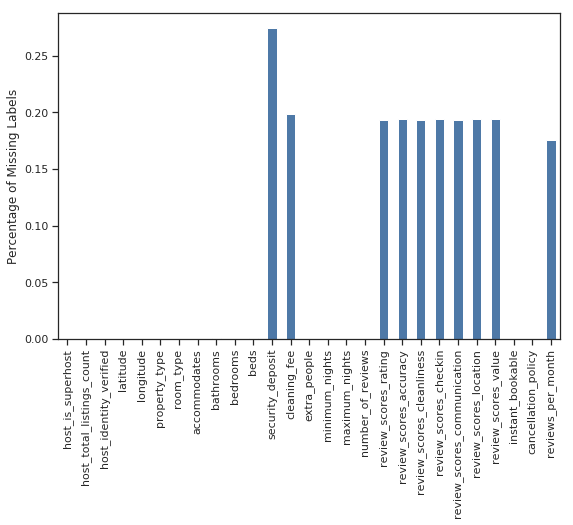

In [ ]:
#plot feature emptiness for train set
feature_emptiness_train = x_train.isnull().sum()/6990
feature_emptiness_train.plot(kind = "bar")
plt.ylabel("Percentage of Missing Labels")

Text(0, 0.5, 'Percentage of Missing Labels')

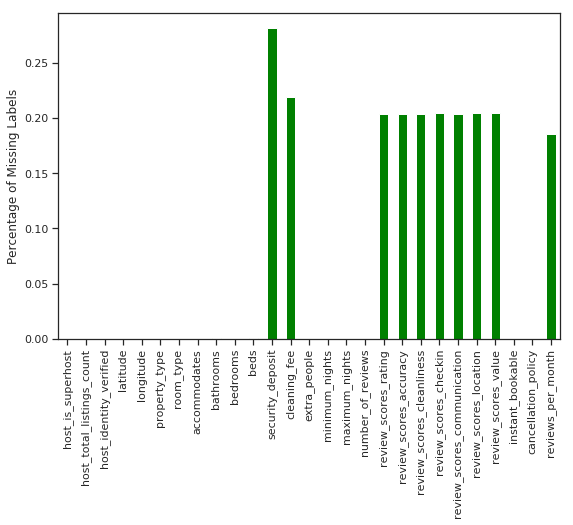

In [ ]:
#plot feature emptiness for test set
feature_emptiness_test = x_test.isnull().sum()/7000
feature_emptiness_test.plot(kind = "bar", color = "green")
plt.ylabel("Percentage of Missing Labels")

In [ ]:
#sorting variables into categorical and numerical 
categorical_variables = []
numerical_variables = []

for col_name in x_train.columns:
    if x_train[col_name].dtypes == 'object':
        unique_cat = len(x_train[col_name].unique())
        categorical_variables.append(col_name)
        print("Feature '{col_name}' has {unique_cat} unique categories".format(
            col_name=col_name, unique_cat=unique_cat))
    else:
      if col_name == "price":
        continue
      numerical_variables.append(col_name)

Feature 'host_is_superhost' has 2 unique categories
Feature 'host_identity_verified' has 2 unique categories
Feature 'property_type' has 30 unique categories
Feature 'room_type' has 3 unique categories
Feature 'instant_bookable' has 2 unique categories
Feature 'cancellation_policy' has 4 unique categories


In [ ]:
#add 0's to cleaning_fee and security_deposit
x_train["cleaning_fee"] = x_train["cleaning_fee"].fillna(0)
x_train["security_deposit"] = x_train["security_deposit"].fillna(0)
x_test["cleaning_fee"] = x_test["cleaning_fee"].fillna(0)
x_test["security_deposit"] = x_test["security_deposit"].fillna(0)

In [ ]:
#create dummy variables in test and train set 
x_train = pd.get_dummies(x_train, prefix = categorical_variables, columns = categorical_variables)
x_test = pd.get_dummies(x_test, prefix = categorical_variables, columns = categorical_variables)

In [ ]:
x_train.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_is_superhost_f,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,-37.81554,144.96526,4,0.5,1.0,0.0,300.0,11.0,27,1,25,115,98.0,10.0,10.0,10.0,10.0,10.0,10.0,3.68,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,18,-37.91984,145.03395,6,2.0,2.0,3.0,200.0,120.0,10,1,1125,4,95.0,10.0,9.0,10.0,10.0,10.0,10.0,0.82,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,1,-37.64818,145.54512,6,1.0,3.0,4.0,0.0,20.0,0,1,1124,200,93.0,9.0,9.0,10.0,10.0,10.0,9.0,5.50,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,1,-37.80245,144.98457,4,2.5,2.0,2.0,0.0,50.0,0,1,30,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.26,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
5,2,-37.81796,144.96541,2,1.0,1.0,1.0,200.0,45.0,0,1,14,129,98.0,10.0,10.0,10.0,10.0,10.0,10.0,8.06,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [ ]:
#impute the missing values for reviews using IterativeImputer
x_train = impute_missing(x_train, x_train.columns)
x_test = impute_missing(x_test, x_test.columns)

In [ ]:
x_test.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_is_superhost_f,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1,1.0,-37.83753,144.99377,2.0,1.0,1.0,1.0,150.0,20.0,0.0,6.0,14.0,0.0,94.098465,9.657321,9.405645,9.673572,9.711052,9.790077,9.474135,0.903207,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,-37.78394,145.13532,8.0,2.5,2.0,6.0,800.0,80.0,25.0,1.0,1125.0,0.0,93.830348,9.539997,9.383835,9.707690,9.774974,9.715541,9.359697,0.638786,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,-37.85689,144.96972,4.0,1.0,1.0,2.0,250.0,75.0,25.0,2.0,1125.0,56.0,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.320000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,-37.85946,144.97905,2.0,1.0,1.0,1.0,0.0,90.0,0.0,7.0,30.0,11.0,98.000000,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000,0.140000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5.0,-37.78225,145.15505,8.0,2.0,4.0,5.0,600.0,210.0,0.0,3.0,1125.0,5.0,88.000000,8.000000,8.000000,10.000000,10.000000,9.000000,8.000000,0.860000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#x_train missing some dummy variables so add them in 
x_train["cancellation_policy_super_strict_30"] = [0] * len(x_train)
x_train["property_type_Castle"] = [0] * len(x_train)
x_train["property_type_Train"] = [0] * len(x_train)
x_train["property_type_Barn"] = [0] * len(x_train)

### Helper functions 

In [ ]:
#function to create kaggle submission csv. 
def create_submission(y_pred):
  '''Create submission file'''
  
  ids = np.arange(1, len(y_pred)+1)
  submission = pd.DataFrame(np.c_[x_test.index, y_pred], columns=['Id', 'Predicted'])
  submission['Id'] = submission['Id'].astype(int)
  submission.to_csv('kaggle_submission.csv',  index=False)
  

In [ ]:
def unlog_predictions(y_pred, y_train, y_fit): 
  '''Function to unlog the price predictions with a bias adjustment'''
  
  bias_adjustment = np.mean(np.exp(y_train-y_fit))
  y_pred = np.exp(y_pred)*bias_adjustment
  
  #fill in the actual prices from the test set 
  y_pred[555] = 0
  y_pred[556] = 9999
  y_pred[747] = 0
  y_pred[1009] = 9999
  y_pred[1287] = 9999
  y_pred[1627] = 0
  y_pred[1950] = 0
  y_pred[1960] = 9999
  y_pred[2113] = 9999
  y_pred[2475] = 9999
  y_pred[3563] = 9999
  y_pred[4047] = 0
  y_pred[4318] = 9999
  y_pred[5357] = 9999
  y_pred[5449] = 12624
  y_pred[5925] = 0
  y_pred[6105] = 0
  y_pred[6227] = 9999
  y_pred[6540] = 9999
  
  return y_pred 

## Exploratory Data Analysis

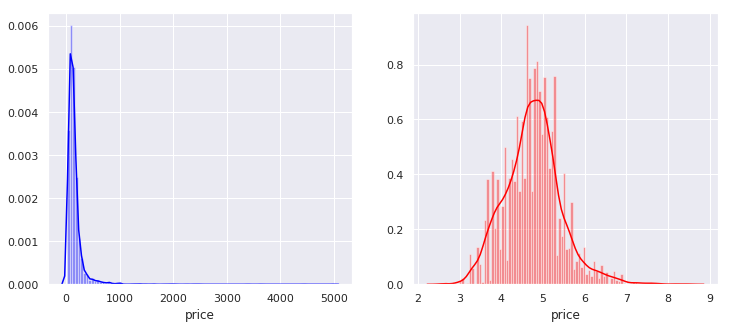

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.distplot(np.exp(y_train), bins = 100, color = 'blue', ax = ax[0])
sns.distplot(y_train, bins = 100, color = 'red', ax = ax[1])

In [ ]:
data.corr().round(3)[['price']].sort_values(by="price", ascending = False) # to see the corelations 

,price
price,1.000
cleaning_fee,0.520
bedrooms,0.484
accommodates,0.457
bathrooms,0.441
beds,0.431
security_deposit,0.427
host_total_listings_count,0.161
extra_people,0.097
review_scores_location,0.074


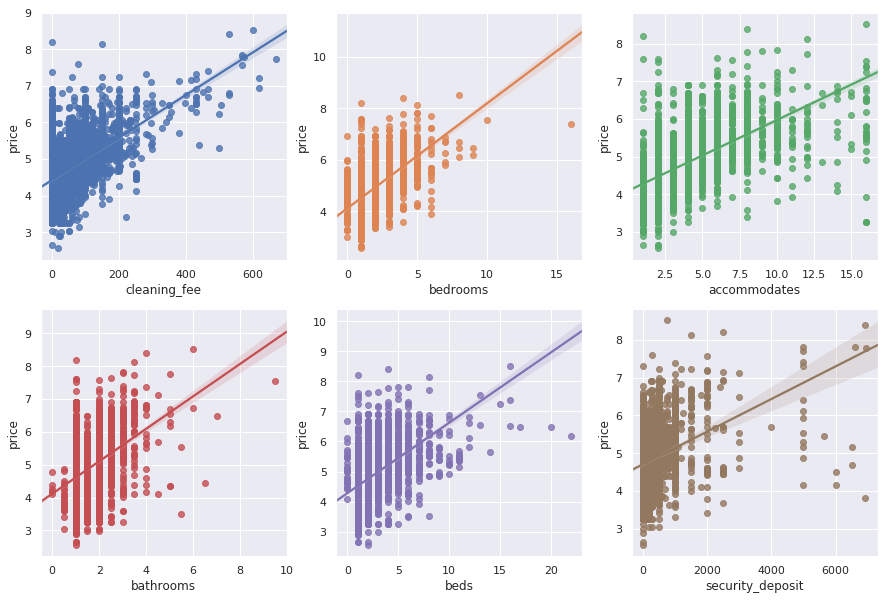

In [ ]:
#scatter plot to check for linear relationships 
fig, ax = plt.subplots(2,3, figsize = (15,10))
sns.regplot(x_train["cleaning_fee"], y_train, ax = ax[0][0])
sns.regplot(x_train["bedrooms"], y_train, ax = ax[0][1])
sns.regplot(x_train["accommodates"], y_train, ax = ax[0][2])
sns.regplot(x_train["bathrooms"], y_train, ax = ax[1][0])
sns.regplot(x_train["beds"], y_train, ax = ax[1][1])
sns.regplot(x_train["security_deposit"], y_train, ax = ax[1][2])
plt.show()

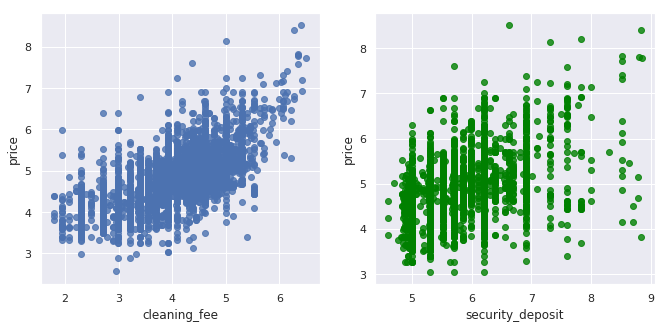

In [ ]:
#taking a closer look at cleaning_fee and security_deposit with the 0's removed 
fig, ax = plt.subplots(1,2, figsize = (11,5))
sns.regplot(np.log(x_train["cleaning_fee"]), y_train, ax = ax[0])
sns.regplot(np.log(x_train["security_deposit"]), y_train, ax = ax[1], color = "green")

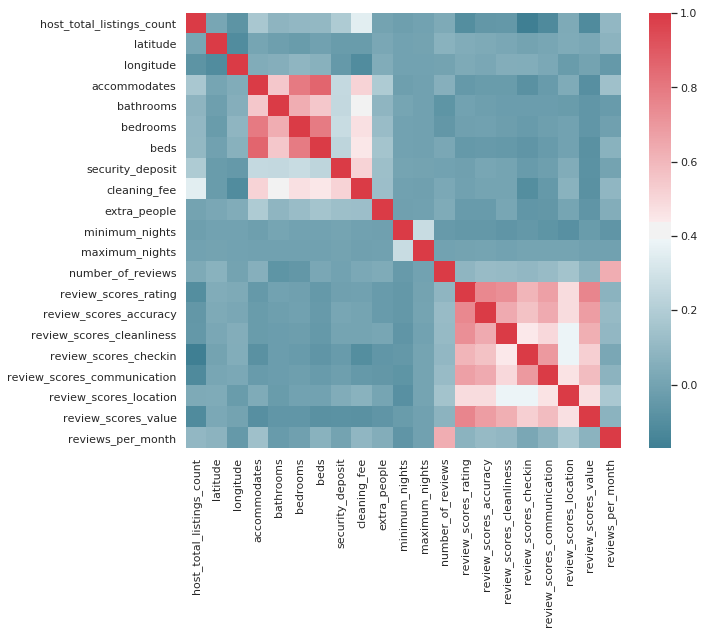

In [ ]:
#analyse the correlation between numerical predictors
f, ax = plt.subplots(figsize=(10, 8))
corr = x_train[numerical_variables].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

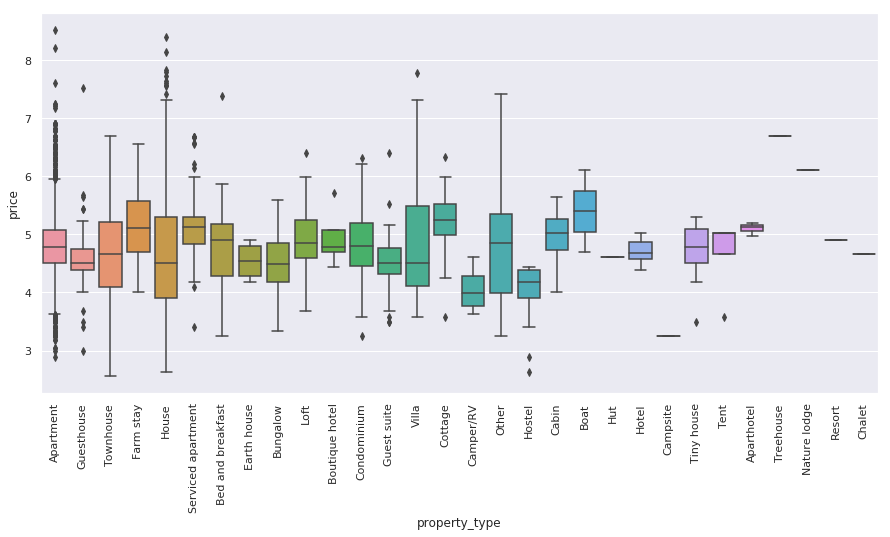

In [ ]:
#boxplots 
data["price"] = np.log(data["price"])
plt.figure(figsize=(15, 7))
property_type_boxplot = sns.boxplot(x = "property_type", y = "price", data = data)
property_type_boxplot.set_xticklabels(property_type_boxplot.get_xticklabels(), rotation=90)
plt.show()

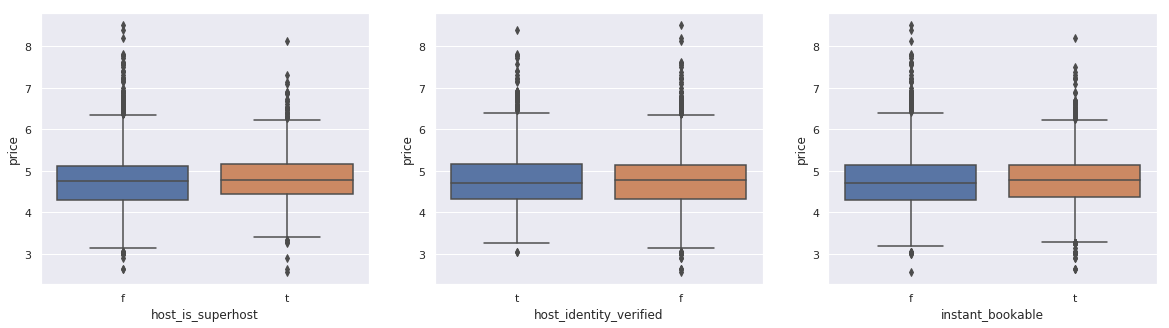

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))
labels = ["host_is_superhost", "host_identity_verified", "instant_bookable"]
for i in range(0, 3): 
    plot = sns.boxplot(x = labels[i], y = "price", data = data, ax = ax[i])

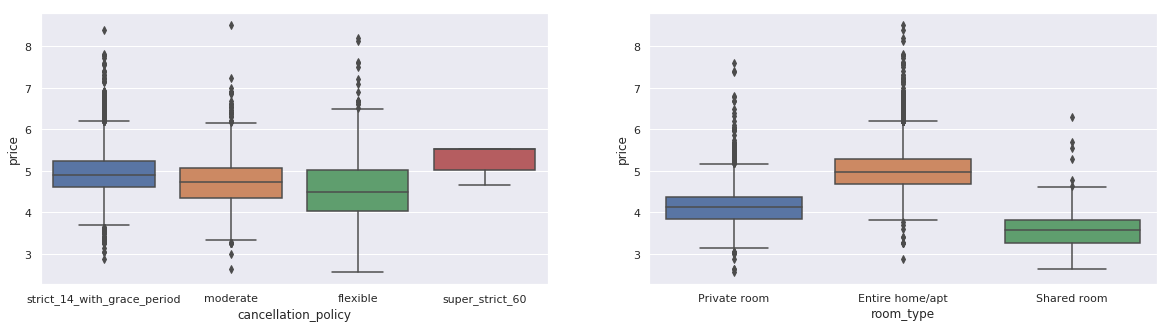

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
labels = ["cancellation_policy", "room_type"]
for i in range(0, 2): 
    plot = sns.boxplot(x = labels[i], y = "price", data = data, ax = ax[i])

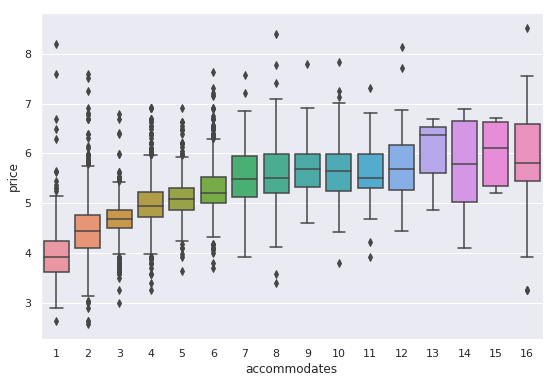

In [ ]:
#accommodates vs. price
sns.boxplot(x="accommodates", y = "price", data = data)

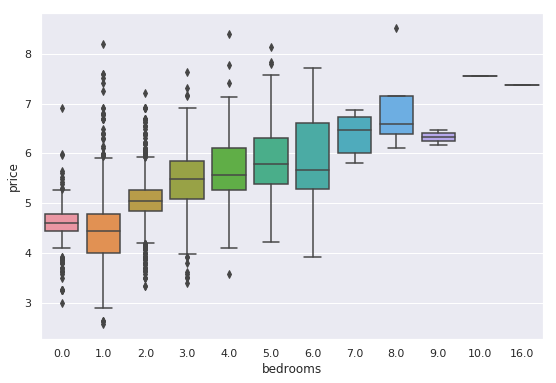

In [ ]:
#bedrooms vs. price 
sns.boxplot(x="bedrooms", y = "price", data = data)

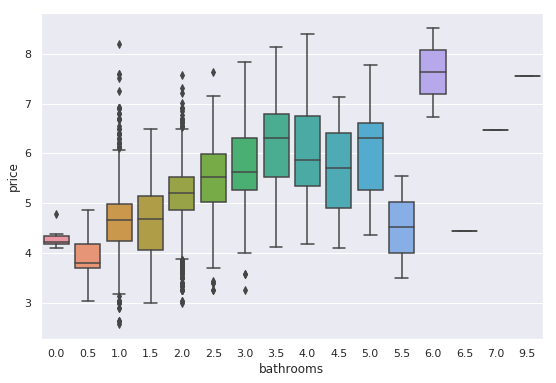

In [ ]:
#bathrooms vs. price 
sns.boxplot(x="bathrooms", y = "price", data = data)

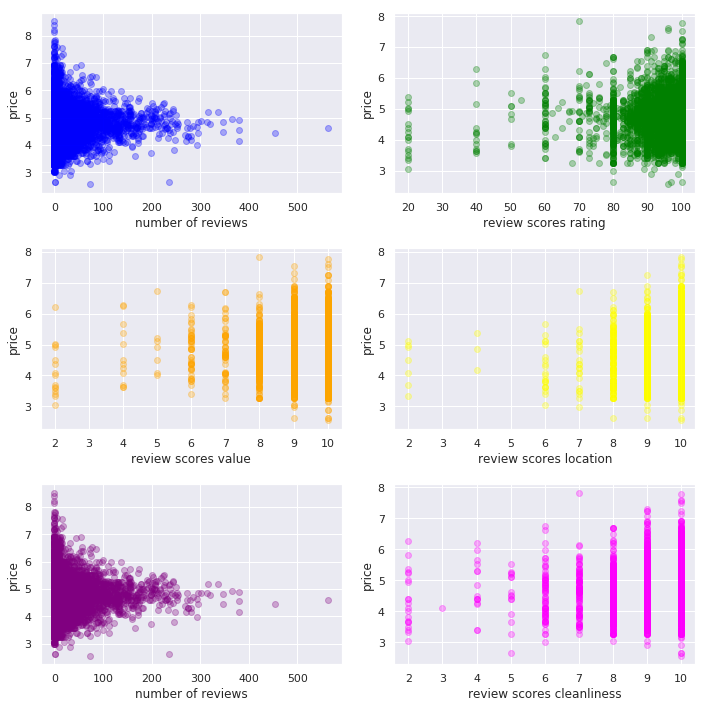

In [ ]:
#reviews vs. price analysis 
def plot_scatter(x, y, x_label, axes, color, y_label = "price"):
  '''Function for plotting scatter plot.'''
  axes.scatter(x, y, alpha = 0.3, color = color)
  axes.set_xlabel(x_label)
  axes.set_ylabel(y_label)
  
  return axes

fig, ax = plt.subplots(3, 2, figsize = (10,10))
ax1 = plot_scatter(data["number_of_reviews"], data["price"], "number of reviews", ax[0,0], "blue")
ax2 = plot_scatter(data["review_scores_rating"], data["price"], "review scores rating", ax[0,1], "green")
ax3 = plot_scatter(data["review_scores_value"], data["price"], "review scores value", ax[1,0],"orange")
ax4 = plot_scatter(data["review_scores_location"], data["price"], "review scores location", ax[1,1], "yellow")
ax5 = plot_scatter(data["number_of_reviews"], data["price"], "number of reviews", ax[2,0], "purple")
ax6 = plot_scatter(data["review_scores_cleanliness"], data["price"], "review scores cleanliness", ax[2,1], "magenta")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'price')

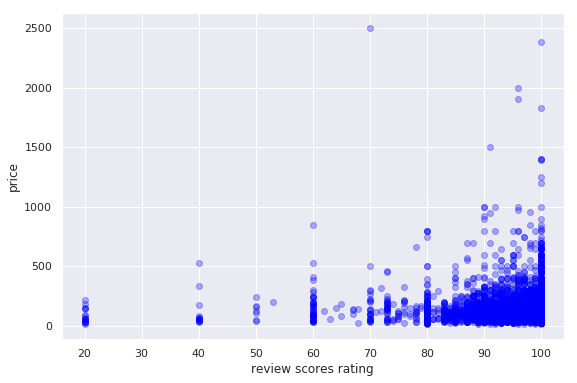

In [ ]:
#closer look at review scores rating 
plt.scatter(data["review_scores_rating"], np.exp(data["price"]), color = "blue", alpha = 0.3)
plt.xlabel("review scores rating")
plt.ylabel("price")

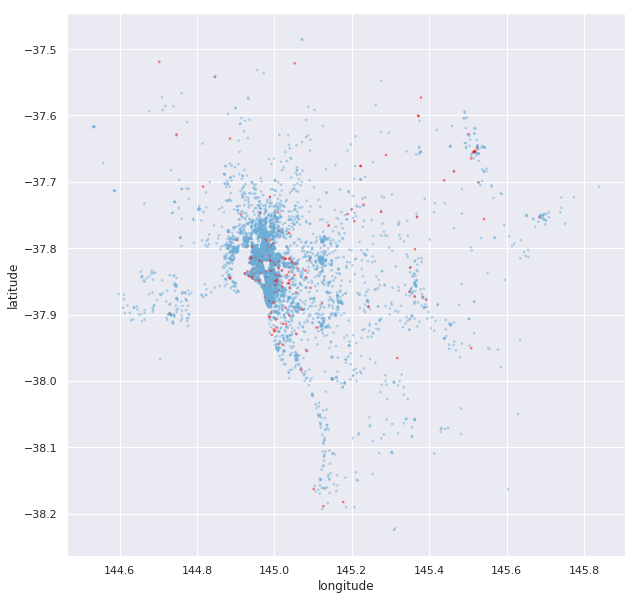

In [ ]:
#location vs. prices 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#red means prices are > 400
colors = np.where(np.exp(data["price"]) > 400,'red','#6badd6')
ax.scatter(data['longitude'],data['latitude'],c = colors, s=7,linewidth=0, alpha = 0.5) 
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
plt.show()

## Data Transformation

### Standardise predictors 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train[numerical_variables])
scaler.fit(x_test[numerical_variables])

#only standardise the numerical variables
x_train_features = scaler.transform(x_train[numerical_variables]) 
x_test_features = scaler.transform(x_test[numerical_variables])

#put the scaled numerical variables back to the original training set
x_train_scaled[numerical_variables] = x_train_features
x_test_scaled[numerical_variables] = x_test_features

In [ ]:
x_train_scaled.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_is_superhost_f,host_is_superhost_t,host_identity_verified_f,host_identity_verified_t,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Hut,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60,cancellation_policy_super_strict_30,property_type_Castle,property_type_Train,property_type_Barn
1,-0.336062,0.151741,-0.350003,0.196206,-1.355429,-0.583816,-1.304783,0.157695,-0.693331,0.568424,-0.147624,-0.535179,2.156896,0.514711,0.484919,0.676991,0.427512,0.382418,0.43719,0.664773,1.351798,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
2,0.293510,-1.456392,0.181797,1.080014,1.175021,0.463253,0.605885,-0.064995,1.067916,-0.169821,-0.147624,0.314739,-0.479477,0.128749,0.484919,-0.408522,0.427512,0.382418,0.43719,0.664773,-0.438454,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,0,0
3,-0.375410,2.732154,4.139288,1.080014,-0.511946,1.510323,1.242774,-0.510375,-0.547907,-0.604083,-0.147624,0.313966,4.175741,-0.128558,-0.798459,-0.408522,0.427512,0.382418,0.43719,-0.557067,2.491049,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0
4,-0.375410,0.353567,-0.200505,0.196206,2.018505,0.463253,-0.031005,-0.510375,-0.063160,-0.604083,-0.147624,-0.531316,-0.503228,0.772018,0.484919,0.676991,0.427512,0.382418,0.43719,0.664773,-0.788993,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0
5,-0.336062,0.114428,-0.348842,-0.687603,-0.511946,-0.583816,-0.667894,-0.064995,-0.143951,-0.604083,-0.147624,-0.543678,2.489412,0.514711,0.484919,0.676991,0.427512,0.382418,0.43719,0.664773,4.093513,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0


## Prediction Models

### Lasso Regression

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lasso = LassoCV(cv = 10)
lasso.fit(x_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Text(0.5, 0, 'Coefficient')

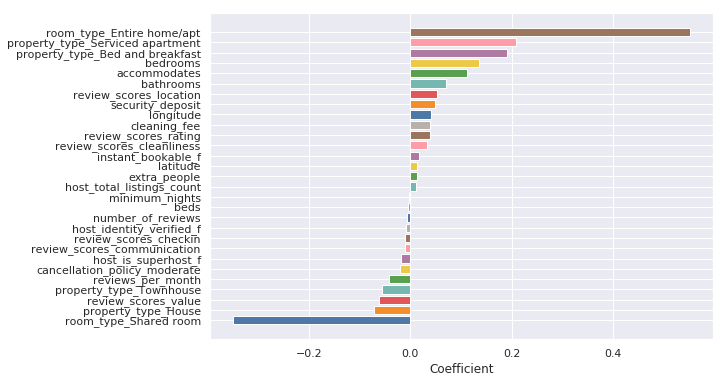

In [ ]:
#plt.figure(figsize=(12,12))
lasso_coefs_df = pd.DataFrame({"attributes": x_train.columns, "coefficients": lasso.coef_})
lasso_coefs_df = lasso_coefs_df.sort_values("coefficients", ascending = True)
lasso_coefs_df = lasso_coefs_df[(lasso_coefs_df["coefficients"] > 0.001) | (lasso_coefs_df["coefficients"] < -0.001)]
plt.barh(lasso_coefs_df["attributes"], lasso_coefs_df["coefficients"], orientation = "horizontal", color = crayon)
plt.xlabel("Coefficient")

In [ ]:
y_fit_lasso = lasso.predict(x_train_scaled)
y_pred_lasso = lasso.predict(x_test_scaled) 
y_pred_lasso = unlog_predictions(y_pred_lasso, y_train, y_fit_lasso) #unlog the price predictions. 

In [ ]:
y_pred_lasso

array([ 73.13256599, 162.79115112,  88.44310988, ...,  69.67817132,
        81.10302648,  71.83554807])

In [ ]:
create_submission(y_pred_lasso)

In [ ]:
features = ["room_type_Entire home/apt", "room_type_Shared room",  "room_type_Private room", 
            "review_scores_rating", "bedrooms", "bathrooms", "review_scores_location", 
            "security_deposit", "cleaning_fee", "longitude", "reviews_per_month",
             "latitude"]

# features from xgboost
# features = ["latitude", "longitude", "reviews_per_month", "host_total_listings_count",
#            "cleaning_fee", "maximum_nights", "review_scores_rating", "number_of_reviews",
#            "extra_people", "accommodates", "security_deposit", "minimum_nights",
#            "review_scores_value", "review_scores_cleanliness", "review_scores_location",
#            "bathrooms"]

### Ridge Regression

In [ ]:
%%time
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))
ridge = RidgeCV(alphas, cv = 10) #try leave one out instead? 
ridge.fit(x_train_scaled[features], y_train)

CPU times: user 9.55 s, sys: 6.14 s, total: 15.7 s
Wall time: 7.95 s


Text(0.5, 0, 'Coefficient')

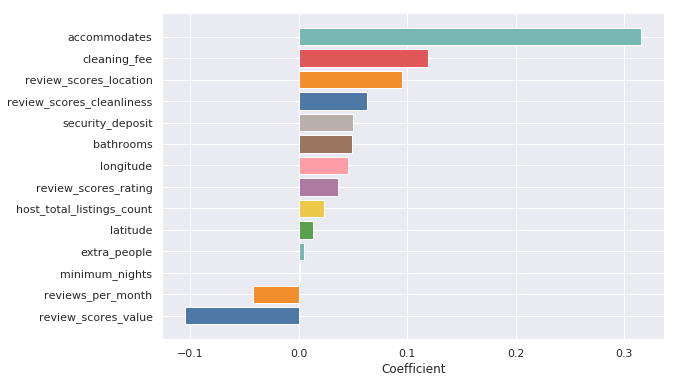

In [ ]:
ridge_coefs_df = pd.DataFrame({"attributes": x_train[features].columns, "coefficients": ridge.coef_})
ridge_coefs_df = ridge_coefs_df.sort_values("coefficients", ascending = True)
ridge_coefs_df = ridge_coefs_df[(ridge_coefs_df["coefficients"] > 0.001) | (ridge_coefs_df["coefficients"] < -0.001)]
plt.barh(ridge_coefs_df["attributes"], ridge_coefs_df["coefficients"], orientation = "horizontal", color = crayon)
plt.xlabel("Coefficient")

In [ ]:
y_fit_ridge = ridge.predict(x_train_scaled[features])
y_pred_ridge = ridge.predict(x_test_scaled[features]) 
y_pred_ridge = unlog_predictions(y_pred_ridge, y_train, y_fit_ridge) #unlog the price predictions. 

In [ ]:
y_pred_ridge

array([ 98.47741043, 335.37519636, 160.72916371, ...,  86.34295952,
       130.46959167, 109.90595047])

In [ ]:
create_submission(y_pred_lasso)

### XGBoost

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time 

xgb_model = xgb.XGBRegressor()

tuning_parameters = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators" : [250, 500, 750, 1000, 1500],
    "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9. 10],
    "subsample" : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(xgb_model, tuning_parameters, n_iter = 20, cv = 10,
                              return_train_score = False, n_jobs = 4,
                              random_state = 20)
gb_search.fit(x_train_scaled, y_train)
print("Best parameters found: ", gb_search.best_params_, "\n")

[04:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 5.0, 'n_estimators': 1500, 'min_child_weight': 3.0, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.25} 

CPU times: user 1min 5s, sys: 745 ms, total: 1min 6s
Wall time: 41min 44s


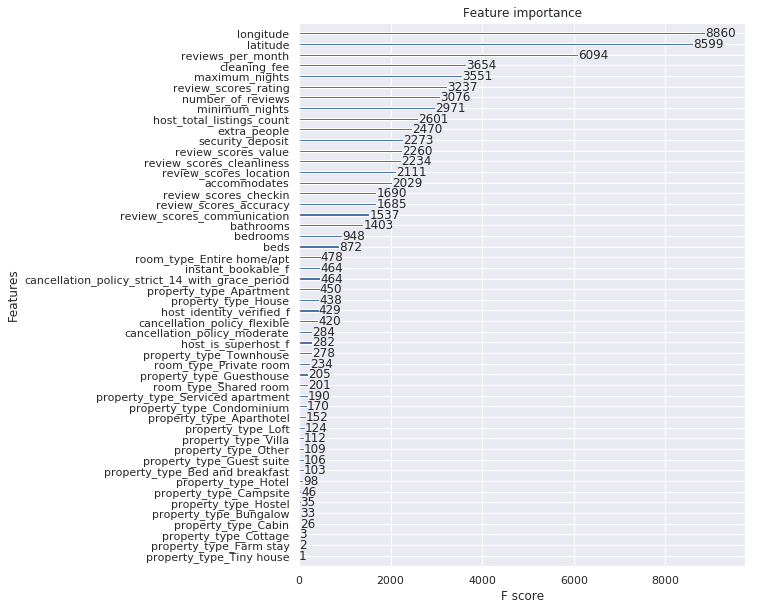

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(gb_search.best_estimator_, ax = ax) 

In [ ]:
#reorder columns for predictions
x_test_scaled = x_test_scaled[x_train_scaled.columns]

In [ ]:
y_fit_gb = gb_search.predict(x_train_scaled)
y_pred_gb = gb_search.predict(x_test_scaled)
y_pred_gb = unlog_predictions(y_pred_gb, y_train, y_fit_gb)
y_pred_gb[0:50]

array([125.30878 , 171.76204 , 129.30907 , 124.61882 , 271.6917  ,
       125.88335 , 118.75684 , 115.510445, 179.01677 , 147.98723 ,
        72.27294 ,  42.89657 , 257.48474 ,  84.84073 ,  80.82792 ,
        75.85517 , 155.73906 , 162.873   , 171.80618 ,  61.644207,
       121.68617 , 153.13931 , 170.08603 , 226.50262 , 247.56541 ,
       150.85652 ,  67.578384, 166.80023 ,  43.442574, 120.07836 ,
       364.05203 , 167.29967 ,  64.470375,  81.09963 , 154.14374 ,
       101.917534,  23.445078,  49.600925,  62.084602, 393.7475  ,
       125.43169 , 119.98586 , 281.45407 , 130.1091  , 209.00218 ,
        83.04178 ,  87.01866 ,  83.48538 , 251.5904  , 215.2948  ],
      dtype=float32)

In [ ]:
create_submission(y_pred_gb)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#n_estimators = number of trees in the forest
rf_model = RandomForestRegressor(n_estimators = 100) 
tuning_parameters = {
    #the number of features to consider when looking for best split.
    'max_features': np.arange(1, x_train.shape[1], 2),
    #minimum number of samples required to be at the leaf node.
    'min_samples_leaf': [1, 5, 10, 20, 50]
}
rf_search = RandomizedSearchCV(rf_model, tuning_parameters, cv = 10, n_iter = 20,
                              return_train_score = False, n_jobs = 4, 
                              random_state = 20)

In [ ]:
%%time 
#fitting the random forest model. Takes 6 minutes to run.  
rf_search.fit(x_train_scaled, y_train) 
rf = rf_search.best_estimator_ 
print("Best paramaters: ", rf_search.best_params_, '\n')

Best paramaters:  {'min_samples_leaf': 1, 'max_features': 41} 

CPU times: user 5.1 s, sys: 165 ms, total: 5.27 s
Wall time: 6min 23s


In [ ]:
#rf.n_estimators = 300 #increase the number of trees in our forest
rf.fit(x_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=41, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance')

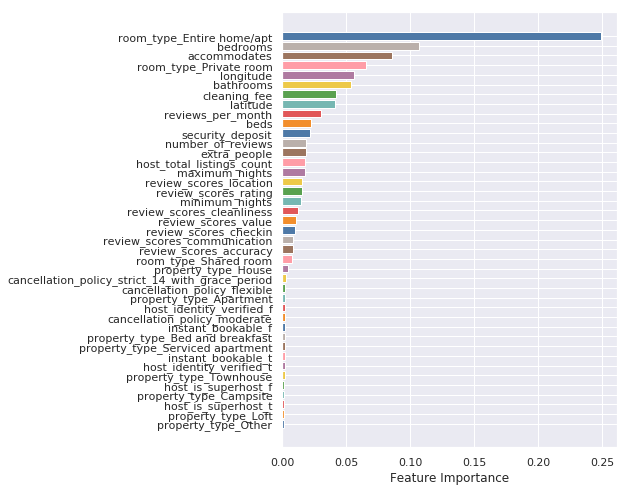

In [ ]:
plt.figure(figsize = (6, 8))
rf_importance_df = pd.DataFrame({"attributes": x_train.columns, "importance": rf.feature_importances_})
rf_importance_df = rf_importance_df.sort_values("importance", ascending = True)
rf_importance_df = rf_importance_df[rf_importance_df["importance"] > 0.001]
plt.barh(rf_importance_df["attributes"], rf_importance_df["importance"], orientation = "horizontal", color = crayon)
plt.xlabel("Feature Importance")

In [ ]:
y_fit_rf = rf.predict(x_train_scaled)
y_pred_rf = rf.predict(x_test_scaled) 
y_pred_rf = unlog_predictions(y_pred_rf, y_train, y_fit_rf)

In [ ]:
y_pred_rf[0:50]

array([ 82.51262424, 122.28287036,  81.52194757,  80.04880855,
       145.26386374, 104.16314607,  77.04205972,  73.41598802,
       101.64358538, 113.29993484,  70.15849887,  83.39732957,
       148.86261922,  82.81212084,  86.07904004,  63.08179423,
       100.91158077, 117.43431099, 100.18042846,  63.24866285,
        74.27048535,  99.86627626, 105.74942883, 142.51849558,
        97.59096231, 133.3348458 ,  65.39207207, 186.00731736,
        49.97070033,  85.8202859 , 210.90208767, 113.49369079,
        64.05848367,  74.5518542 , 117.01580994,  79.23647827,
        40.57119946,  88.7521144 ,  89.27301987, 211.38234263,
        92.36997628,  63.83370047, 192.22064691,  78.65150224,
       103.82334481,  57.82015305,  54.64911913,  80.41611629,
       159.48633679, 109.97346471])

In [ ]:
create_submission(y_pred_rf)

### Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense 
from keras.regularizers import l2
from keras.callbacks import History
history = History()

In [ ]:
#Build model architecture 
ann_model = Sequential()
#try 2 layers with 32 neurons
ann_model.add(Dense(32, activation = "relu", input_shape = (x_train_scaled[features].shape[1],), 
                kernel_regularizer = l2(0.1)))
ann_model.add(Dense(32, activation = "relu"))
ann_model.add(Dense(1, activation = "relu"))
ann_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann_model.compile(optimizer = "adam", loss ="mean_squared_error")

In [ ]:
%%time 
#fit the model - use the scaled values 
history = ann_model.fit(x_train_scaled[features], y_train, batch_size = 128, verbose = 1, 
                    epochs = 1000, callbacks = [history])


Epoch 1/1000
6990/6990 [==============================] - 0s 47us/step - loss: 1306.5756
Epoch 2/1000
6990/6990 [==============================] - 0s 22us/step - loss: 28801.9545
Epoch 3/1000
6990/6990 [==============================] - 0s 21us/step - loss: 1667.2442
Epoch 4/1000
6990/6990 [==============================] - 0s 21us/step - loss: 285.8330
Epoch 5/1000
6990/6990 [==============================] - 0s 22us/step - loss: 3.9168
Epoch 6/1000
6990/6990 [==============================] - 0s 22us/step - loss: 3.4424
Epoch 7/1000
6990/6990 [==============================] - 0s 21us/step - loss: 94.2668
Epoch 8/1000
6990/6990 [==============================] - 0s 24us/step - loss: 2.7092
Epoch 9/1000
6990/6990 [==============================] - 0s 21us/step - loss: 2.3983
Epoch 10/1000
6990/6990 [==============================] - 0s 22us/step - loss: 2.1223
Epoch 11/1000
6990/6990 [==============================] - 0s 22us/step - loss: 2331.3516
Epoch 12/1000
6990/6990 [===========

Text(0, 0.5, 'Loss')

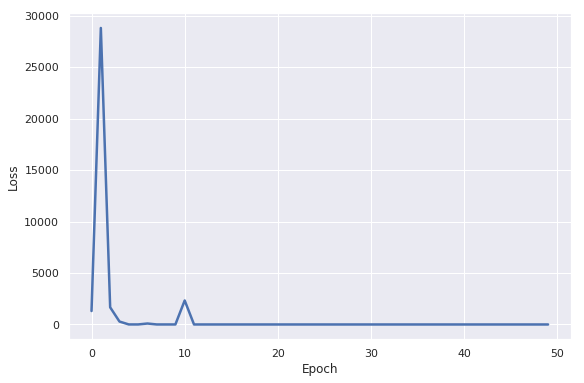

In [ ]:
plt.plot(history.history["loss"][0:50], linewidth = 2.5) #plot first 100 validation losses 
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
y_fit_ann = ann_model.predict(x_train_scaled[features]).flatten()
y_pred_ann = ann_model.predict(x_test_scaled[features]).flatten()
y_pred_ann = unlog_predictions(y_pred_ann, y_train, y_fit_ann)
y_pred_ann

array([103.4619  , 242.88033 , 159.9877  , ...,  69.369415, 143.05089 ,
       107.19071 ], dtype=float32)

In [ ]:
create_submission(y_pred_ann)

### KNN

In [ ]:
#knn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

k_range = range(1,30)
weights = ["uniform", "distance"]
parameters = dict(n_neighbors = k_range, weights = weights)

knn = KNeighborsRegressor()
knn_search = RandomizedSearchCV(knn, parameters, cv = 10,
                               scoring = "neg_mean_squared_error", n_iter = 10,
                               random_state = 10)

In [ ]:
%%time
knn_model = knn_search.fit(x_train_scaled[features], y_train)

CPU times: user 5.55 s, sys: 0 ns, total: 5.55 s
Wall time: 5.55 s


In [ ]:
print('Best parameters from this is ',knn_search.best_params_)
print('This is the best KNN estimator', knn_search.best_estimator_)

Best parameters from this is  {'weights': 'distance', 'n_neighbors': 16}
This is the best KNN estimator KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                    weights='distance')


In [ ]:
y_fit_knn = knn_model.predict(x_train_scaled[features])
y_pred_knn = knn_model.predict(x_test_scaled[features])
y_pred_knn = unlog_predictions(y_pred_knn, y_train, y_fit_knn)
y_pred_knn[0:50]

array([105.95159192, 208.39319579, 127.1995301 , 112.64021503,
       211.65957876,  66.0948854 , 119.84385925,  91.01212627,
       239.53614907, 142.54872037, 145.34396657,  66.84645651,
       261.02120802,  77.72464955,  81.23149597,  87.1734907 ,
       138.02977832, 214.06939617, 113.55392064,  89.06421504,
       122.0669411 , 164.55463659, 151.30388   , 188.84484443,
       129.75599802, 123.7363448 , 102.81141354, 153.58226578,
        66.12401865, 130.92781892, 289.37551583, 126.9880298 ,
        82.52694842,  92.28805809, 113.38670276,  55.24915495,
        41.63627313, 139.91265243,  74.3226485 , 293.94575755,
        84.98431667,  90.80899142, 224.37104332, 126.14451794,
       201.50187653,  86.27683663,  74.91219069,  77.09799551,
       251.57880394, 250.42412328])

In [ ]:
create_submission(y_pred_knn)

### Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

lgb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 64, cv = 10, return_train_score=False, n_jobs=4, 
                               random_state = 20)

lgb_search.fit(x_train_scaled, y_train)

lbst = lgb_search.best_estimator_

In [ ]:
y_fit_lgb = lgb_search.predict(x_train_scaled)
y_pred_lgb = lgb_search.predict(x_test_scaled)
y_pred_lgb = unlog_predictions(y_pred_lgb, y_train, y_fit_lgb)
y_pred_lgb[0:50]

array([133.22445943, 185.29184935, 138.69726505, 136.73137354,
       257.15767508, 131.78272118, 120.70594608, 124.18664717,
       166.79789366, 152.51139748,  76.73568123,  40.42907858,
       257.47952978,  79.19356516,  72.30974969,  73.55067844,
       158.03168556, 154.08005854, 161.86704702,  66.1719094 ,
       122.86913608, 150.09546798, 172.1696758 , 203.25468918,
       245.89817049, 153.63592111,  72.25560879, 205.93930583,
        40.94936699, 131.0170615 , 333.92614531, 184.99945783,
        68.36411176,  76.73423721, 162.66064233,  98.77506595,
        19.93687614,  65.07977636,  84.66401031, 381.14011347,
       130.75666133, 125.33154191, 270.47208686, 130.34643122,
       210.66423303,  79.48373409,  97.15922644,  93.73477011,
       261.61063277, 222.43794489])

In [ ]:
create_submission(y_pred_lgb)

### Stepwise Regression

***Creating and adding Dummy variables to train data***

In [ ]:
handle_cat_train = x_train.copy()

In [ ]:
handle_cat_train.shape

(6990, 31)

In [ ]:
handle_cat_train["host_is_superhost"] = handle_cat_train["host_is_superhost"].astype('category')
handle_cat_train["host_identity_verified"] = handle_cat_train["host_identity_verified"].astype('category')
handle_cat_train["property_type"] = handle_cat_train["property_type"].astype('category')
handle_cat_train["room_type"] = handle_cat_train["room_type"].astype('category')
handle_cat_train["instant_bookable"] = handle_cat_train["instant_bookable"].astype('category')
handle_cat_train["cancellation_policy"] = handle_cat_train["cancellation_policy"].astype('category')
handle_cat_train.dtypes

host_is_superhost                      category
host_total_listings_count                 int64
host_identity_verified                 category
latitude                                float64
longitude                               float64
property_type                          category
room_type                              category
accommodates                              int64
bathrooms                               float64
bedrooms                                float64
beds                                    float64
security_deposit                        float64
cleaning_fee                            float64
extra_people                              int64
minimum_nights                            int64
maximum_nights                            int64
number_of_reviews                         int64
review_scores_rating                    float64
review_scores_accuracy                  float64
review_scores_cleanliness               float64
review_scores_checkin                   

In [ ]:
handle_cat_train["host_is_superhost"] = handle_cat_train["host_is_superhost"].cat.codes
handle_cat_train["host_identity_verified"] = handle_cat_train["host_identity_verified"].cat.codes
handle_cat_train["property_type"] = handle_cat_train["property_type"].cat.codes
handle_cat_train["room_type"] = handle_cat_train["room_type"].cat.codes
handle_cat_train["instant_bookable"] = handle_cat_train["instant_bookable"].cat.codes
handle_cat_train["cancellation_policy"] = handle_cat_train["cancellation_policy"].cat.codes
handle_cat_train.head()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,cancellation_policy_super_strict_30,property_type_Castle,property_type_Train,property_type_Barn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,2,1,-37.81554,144.96526,1,1,4,0.5,1.0,0.0,300.0,11.0,27,1,25,115,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,2,3.68,0,0,0,0
2,0,18,0,-37.91984,145.03395,1,0,6,2.0,2.0,3.0,200.0,120.0,10,1,1125,4,95.0,10.0,9.0,10.0,10.0,10.0,10.0,1,1,0.82,0,0,0,0
3,0,1,1,-37.64818,145.54512,15,0,6,1.0,3.0,4.0,0.0,20.0,0,1,1124,200,93.0,9.0,9.0,10.0,10.0,10.0,9.0,1,2,5.50,0,0,0,0
4,0,1,1,-37.80245,144.98457,1,0,4,2.5,2.0,2.0,0.0,50.0,0,1,30,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0.26,0,0,0,0
5,1,2,0,-37.81796,144.96541,1,0,2,1.0,1.0,1.0,200.0,45.0,0,1,14,129,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2,8.06,0,0,0,0


In [ ]:
handle_cat_test = x_test.copy()

In [ ]:
handle_cat_test["host_is_superhost"] = handle_cat_test["host_is_superhost"].astype('category')
handle_cat_test["host_identity_verified"] = handle_cat_test["host_identity_verified"].astype('category')
handle_cat_test["property_type"] = handle_cat_test["property_type"].astype('category')
handle_cat_test["room_type"] = handle_cat_test["room_type"].astype('category')
handle_cat_test["instant_bookable"] = handle_cat_test["instant_bookable"].astype('category')
handle_cat_test["cancellation_policy"] = handle_cat_test["cancellation_policy"].astype('category')
handle_cat_test.dtypes

host_is_superhost              category
host_total_listings_count         int64
host_identity_verified         category
latitude                        float64
longitude                       float64
property_type                  category
room_type                      category
accommodates                      int64
bathrooms                       float64
bedrooms                          int64
beds                            float64
security_deposit                float64
cleaning_fee                    float64
extra_people                      int64
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64
instant_bookable               category


***Creating and adding Dummy variables to test data***

In [ ]:
handle_cat_test["host_is_superhost"] = handle_cat_test["host_is_superhost"].cat.codes
handle_cat_test["host_identity_verified"] = handle_cat_test["host_identity_verified"].cat.codes
handle_cat_test["property_type"] = handle_cat_test["property_type"].cat.codes
handle_cat_test["room_type"] = handle_cat_test["room_type"].cat.codes
handle_cat_test["instant_bookable"] = handle_cat_test["instant_bookable"].cat.codes
handle_cat_test["cancellation_policy"] = handle_cat_test["cancellation_policy"].cat.codes
handle_cat_test.head()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,-37.83753,144.99377,1,0,2,1.0,1,1.0,150.0,20.0,0,6,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN
2,0,3,1,-37.78394,145.13532,29,0,8,2.5,2,6.0,800.0,80.0,25,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,0,1,0,-37.85689,144.96972,1,0,4,1.0,1,2.0,250.0,75.0,25,2,1125,56,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,2,2.32
4,0,1,1,-37.85946,144.97905,1,0,2,1.0,1,1.0,0.0,90.0,0,7,30,11,98.0,10.0,9.0,10.0,10.0,10.0,10.0,0,2,0.14
5,1,5,1,-37.78225,145.15505,20,0,8,2.0,4,5.0,600.0,210.0,0,3,1125,5,88.0,8.0,8.0,10.0,10.0,9.0,8.0,1,2,0.86


In [ ]:
#impute the missing values for reviews using IterativeImputer
handle_cat_train = impute_missing(handle_cat_train, handle_cat_train.columns)
handle_cat_test = impute_missing(handle_cat_test, handle_cat_test.columns)

**Begin stepwise forward multi-linear regression**

In [ ]:
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,Y)
    RSS = mean_squared_error(Y,model.predict(X)) * len(Y)
    R_squared = model.score(X,Y)
    return RSS, R_squared

Run stepwise forward selection loop

In [ ]:
%%time 

#Initialization variables
Y = y_train
X = handle_cat_train
k = len(handle_cat_train.columns) #27 features to consider 

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y) #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

CPU times: user 4.7 s, sys: 5.03 s, total: 9.73 s
Wall time: 5.03 s


In [ ]:
df2 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df2['numb_features'] = df2.index

In [ ]:
pd.set_option('max_colwidth', 1000)

#Initializing useful variables
m = len(Y)
p = 27
hat_sigma_squared = (1/(m - p -1)) * min(df2['RSS'])

#Computing
df2['C_p'] = (1/m) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared )
df2['AIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared )
df2['BIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] +  np.log(m) * df2['numb_features'] * hat_sigma_squared )
df2['R_squared_adj'] = 1 - ( (1 - df2['R_squared'])*(m-1)/(m-df2['numb_features'] -1))
df2['MSE'] = (1/m)*(df2['RSS'])
df2['RMSE'] = df2['MSE']**(1.0/2)
df2

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj,MSE,RMSE
1,[room_type],1942.431276,0.394475,1,0.277941,1.489839,1.490819,0.394389,0.277887,0.527150
2,"[room_type, bedrooms]",1462.367006,0.544128,2,0.209315,1.121988,1.123949,0.543998,0.209208,0.457393
3,"[room_type, bedrooms, bathrooms]",1422.660145,0.556506,3,0.203688,1.091825,1.094766,0.556316,0.203528,0.451141
4,"[room_type, bedrooms, bathrooms, security_deposit]",1392.918646,0.565778,4,0.199487,1.069304,1.073225,0.565529,0.199273,0.446400
5,"[room_type, bedrooms, bathrooms, security_deposit, accommodates]",1370.012416,0.572918,5,0.196263,1.052024,1.056926,0.572613,0.195996,0.442714
6,"[room_type, bedrooms, bathrooms, security_deposit, accommodates, review_scores_location]",1358.955642,0.576365,6,0.194735,1.043831,1.049713,0.576001,0.194414,0.440924
7,"[room_type, bedrooms, bathrooms, security_deposit, accommodates, review_scores_location, reviews_per_month]",1346.841473,0.580142,7,0.193055,1.034828,1.041690,0.579721,0.192681,0.438955
8,"[room_type, bedrooms, bathrooms, security_deposit, accommodates, review_scores_location, reviews_per_month, longitude]",1336.142578,0.583477,8,0.191578,1.026910,1.034752,0.583000,0.191151,0.437208
9,"[room_type, bedrooms, bathrooms, security_deposit, accommodates, review_scores_location, reviews_per_month, longitude, cleaning_fee]",1328.614495,0.585824,9,0.190554,1.021423,1.030245,0.585290,0.190074,0.435974
10,"[room_type, bedrooms, bathrooms, security_deposit, accommodates, review_scores_location, reviews_per_month, longitude, cleaning_fee, review_scores_value]",1323.660883,0.587368,10,0.189899,1.017910,1.027713,0.586777,0.189365,0.435161


Visualise predictor selection performance via criteria

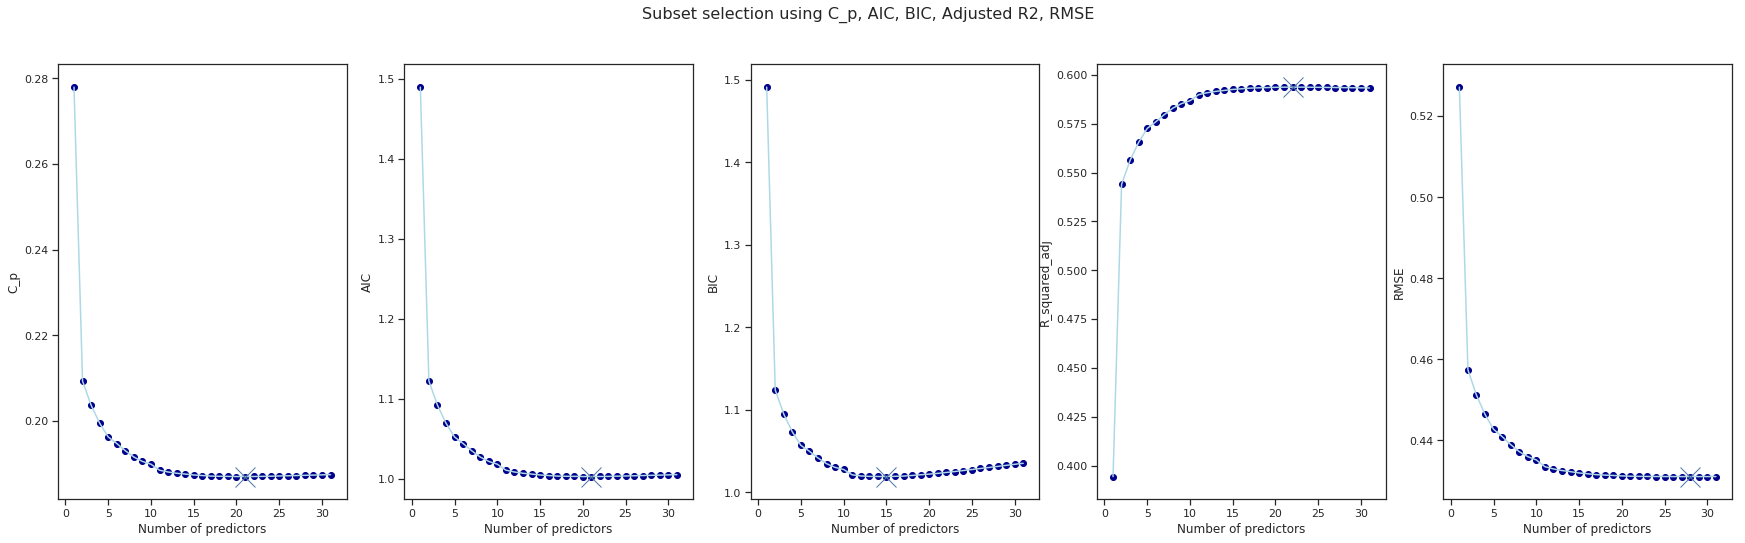

In [ ]:
variables = ['C_p', 'AIC','BIC','R_squared_adj','RMSE']
fig = plt.figure(figsize = (30,8))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 5, i+1)
    ax.plot(df2['numb_features'],df2[v], color = 'lightblue')
    ax.scatter(df2['numb_features'],df2[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df2[v].idxmax(),df2[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df2[v].idxmin(),df2[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2, RMSE', fontsize = 16)
plt.show()

Creating models with selected no. of predictors as per criteria

In [ ]:
#Using BIC - has hasher penalty - to see predictions with 15 regressors

stepwise_features1 = ['room_type', 'bedrooms', 'bathrooms', 'security_deposit', 'accommodates', 'review_scores_location', 'reviews_per_month', 'longitude', 'cleaning_fee', 'review_scores_value', 'review_scores_cleanliness', 'property_type', 'latitude', 'review_scores_rating', 
                     'review_scores_communication']

x_selected1 = handle_cat_train[stepwise_features1]

In [ ]:
#Using Cp and AIC - to see predictions with 21 regressors

stepwise_features2 = ['room_type', 'bedrooms', 'bathrooms', 'security_deposit', 'accommodates', 'review_scores_location', 'reviews_per_month', 'longitude', 'cleaning_fee', 'review_scores_value', 'review_scores_cleanliness', 'property_type', 'latitude', 'review_scores_rating', 
                      'review_scores_communication', 'extra_people', 'host_total_listings_count', 'instant_bookable', 'host_is_superhost', 'number_of_reviews', 'review_scores_checkin']

x_selected2 = x_train_scaled[stepwise_features2]

In [ ]:
#Using adj r2 - to see predictions with 22 regressors

stepwise_features3 = ['room_type', 'bedrooms', 'bathrooms', 'security_deposit', 'accommodates', 'review_scores_location', 'reviews_per_month', 'longitude', 'cleaning_fee', 'review_scores_value', 'review_scores_cleanliness', 'property_type', 'latitude', 'review_scores_rating', 
                      'review_scores_communication', 'extra_people', 'host_total_listings_count', 'instant_bookable', 'host_is_superhost', 'number_of_reviews', 'review_scores_checkin', 'beds']

x_selected3 = x_train_scaled[stepwise_features3]

Forming predictions using selected model

In [ ]:
from sklearn.linear_model import LinearRegression

#fitting linear model with the chosen variables 
lm = LinearRegression()
lm.fit(handle_cat_train[stepwise_features1], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_test.shape

(7000, 27)

In [ ]:
#predicting unlogged prices 
y_fit_lm = lm.predict((handle_cat_train[stepwise_features1]))
y_pred_lm = lm.predict(handle_cat_test[stepwise_features1])
y_pred_lm = unlog_predictions(y_pred_lm, y_train, y_fit_lm)
y_pred_lm[0:50]

array([131.67940111, 271.21598096, 156.51110809, 132.57092407,
       348.45483127, 123.59779056, 132.55735814, 132.86018334,
       193.36555422, 148.40300481,  45.45944725,  46.0922511 ,
       256.91197506,  72.0248657 ,  67.8263805 ,  72.13577901,
       168.21091562, 173.46578169, 157.90668945,  72.41877912,
       145.3431501 , 195.38345814, 190.73250323, 207.76995024,
       174.97684518, 166.22632333,  80.2365973 , 185.85158854,
        54.38163015, 158.7795384 , 275.1135443 , 226.07297702,
        75.54748854,  76.04783567, 173.86818148, 119.81483774,
        40.14638954,  48.69785438,  67.44179825, 276.6616206 ,
       130.27069586, 113.36647305, 247.76112494, 153.97480747,
       202.65488466, 104.9576428 , 119.2617719 ,  76.77397681,
       259.20152183, 199.3289697 ])

In [ ]:
create_submission(y_pred_lm)

### Stacking

In [ ]:
%%time
#!pip install mlxtend
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

models = [lasso, xgb_model, rf, lbst]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(x_train_scaled.values, y_train.ravel())

[14:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
y_fit_stack = stack.predict(x_train_scaled.values)
y_pred_stack = stack.predict(x_test_scaled.values)
y_pred_stack = unlog_predictions(y_pred_stack, y_train, y_fit_stack)
y_pred_stack[0:50]

array([129.907061  , 182.61314183, 125.61114209, 131.71521091,
       244.56585945, 133.66505317, 116.96694953, 119.39541391,
       168.69941272, 144.98823042,  68.20121286,  40.65886285,
       250.65080488,  82.41554331,  71.59191159,  67.81260823,
       155.60161326, 170.36830554, 170.49673579,  64.97909221,
       122.80989782, 152.74779027, 170.55193717, 208.86506083,
       249.63230904, 147.40261404,  69.41514522, 192.61619222,
        39.41564481, 121.74852767, 318.83783289, 174.70291081,
        63.26482363,  74.6096452 , 165.94353996,  97.88103862,
        20.53818827,  62.89895588,  79.75490429, 390.42779906,
       124.84937462, 123.44211906, 283.31187023, 123.80632499,
       213.79590759,  82.56298664,  97.14326592,  93.51045129,
       260.76415583, 218.56258252])

In [ ]:
create_submission(y_pred_stack)